In [1]:
# Check GPU

from tensorflow import test
from tensorflow.python.client import device_lib

if test.is_gpu_available:
    devices=device_lib.list_local_devices()
    gpu=[(x.physical_device_desc) for x in devices if x.device_type == 'GPU']
    print("GPU :", gpu)

GPU : ['device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5']


In [2]:
# Check framework versions being used 

import sys
import keras as K
import tensorflow as tf

print("Python", sys.version)
print("Tensorflow version", tf.__version__)
print("Keras version", K.__version__)

Python 3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]
Tensorflow version 2.1.0
Keras version 2.3.1


Using TensorFlow backend.


In [3]:
# import NN architectures for speech recognition
from models import *

# import function for training acoustic model
from train_utils import train_model

In [4]:
# Import Additional Libraries

import re
import nltk

import numpy as np
import seaborn as sns
import _pickle as pickle
import matplotlib.pyplot as plt

from glob import glob
from nltk import trigrams
from nltk.corpus import brown
from utils import int_sequence_to_text
from collections import Counter, defaultdict
from data_generator import AudioGenerator, plot_raw_audio, plot_spectrogram_feature

from IPython.display import Markdown, display, Audio
from data_generator import vis_train_features, plot_mfcc_feature

In [5]:
sns.set_style(style = 'white')
nltk.download('brown')

[nltk_data] Downloading package brown to /home/tanmay/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [6]:
# Extract label and audio features for a single training example

vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


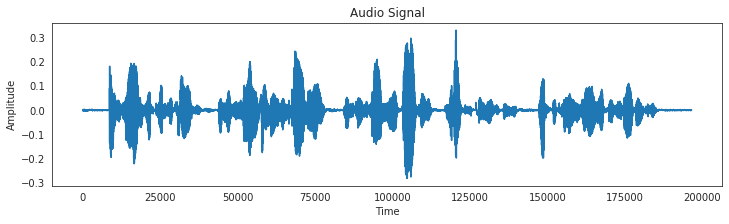

In [7]:
plot_raw_audio(vis_raw_audio)

In [8]:
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))

**Shape of Audio Signal** : (196576,)

In [9]:
display(Markdown('**Transcript** : ' + str(vis_text)))

**Transcript** : and now it had come to pass that his sole remaining ally mister samuel bozzle the ex policeman was becoming weary of his service

In [10]:
Audio(vis_audio_path)

Acoustic Features for Speech Recognition

We won't use the raw audio waveform as input to our model. 
Code first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models. 
Acoustic model will accept the feature representation as input.
We will explore two possible feature representations. 

Spectrograms
The first option for an audio feature representation is the spectrogram. 
The code returns the spectrogram as a 2D tensor, where the first (vertical) dimension indexes time, and the second (horizontal) dimension indexes frequency. 
To speed the convergence of the algorithm, we have also normalized the spectrogram. (We can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

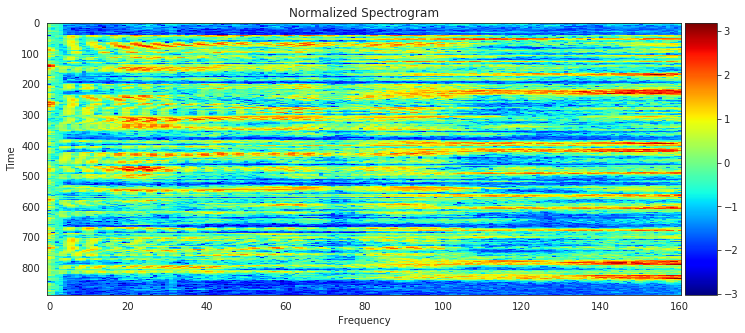

In [11]:
plot_spectrogram_feature(vis_spectrogram_feature)

In [12]:
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

**Shape of Spectrogram** : (890, 161)

Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is MFCCs. 
Just as with the spectrogram features, the MFCCs are normalized in the supplied code.
The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window. 
Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset.

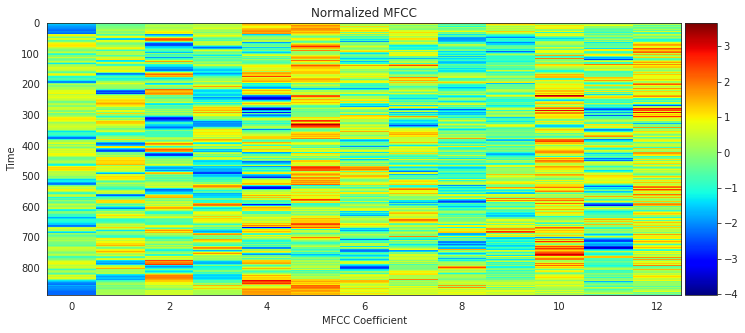

In [13]:
plot_mfcc_feature(vis_mfcc_feature)

In [14]:
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

**Shape of MFCC** : (890, 13)